# Benchmarking Circuit Depth for PEC
***

## Imports

In [81]:
import functools
import os
import time
from typing import List
import matplotlib.pyplot as plt
import cirq
import networkx as nx
import numpy as np
import qiskit
from mitiq import benchmarks, pec

from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit.providers.fake_provider import GenericBackendV2
import qiskit_aer

## Setup Stuff

In [82]:
ideal_backend = qiskit_aer.AerSimulator()

# Random seed for circuit generation.ibm_kolkata_ordering
seed: int = 1

# Display verbose output.
verbose: bool = False
# Give queue updates every this many seconds when running on hardware device.
verbose_update_time: int = 30

## Set up hardware
We need chain-like connectivity for mirror circuits. Physical qubit structure is used for initial_layout argument in the executor.

In [83]:
def get_phys_qubits(n_qubits):
    # Physical qubits with a chain-like connectivity.
    ibm_lima_ordering = [0, 1, 3, 4, 2] 
    ibm_kolkata_ordering = [0, 1, 4, 7, 10, 12, 15, 18, 21, 23, 24, 25, 22, 19, 16, 14, 11, 8, 5, 3, 2]
    ibm_torino_ordering = [14, 13, 12, 11, 10, 
                           9, 8, 7, 6, 5, 
                           4, 3, 2, 1, 0, 
                           15, 19, 20, 21, 22, 
                           23, 24, 25, 26, 27, 
                           28, 29, 30, 31, 32, 33]


    if n_qubits <= len(ibm_lima_ordering):
        # Assume ibmq-lima device. Take n adjacent physical qubits.
        physical_ibm_qubits = ibm_lima_ordering[: n_qubits]
    elif n_qubits <= len(ibm_kolkata_ordering) and n_qubits > len(ibm_lima_ordering):
        # Assume ibmq-kolkata device. Take n adjacent physical qubits.
        physical_ibm_qubits = ibm_kolkata_ordering[: n_qubits]
    elif n_qubits <= len(ibm_torino_ordering) and n_qubits > len(ibm_kolkata_ordering):
        # Assume ibmq-torino device. Take n adjacent physical qubits.
        physical_ibm_qubits = ibm_torino_ordering[: n_qubits]
    else:
        raise ValueError(f"Number of qubits {n_qubits} too large.")
    
    return ibm_torino_ordering[: n_qubits] #physical_ibm_qubits
    # fake_list = []
    # for i in range(0,n_qubits):
    #     fake_list.append(i)
    # return fake_list

In [84]:
print(len([14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 15, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
))

31


## Make connectivity graph for mirror circuits

In [85]:
def get_computer(n_qubits):
    # Make connectivity graph 
    computer = nx.Graph()

    qubits = [j for j in range(n_qubits)]

    # Split qubits into 2-qubit pairs (assuming a chain connectivity).
    rb_pattern = [[qa, qb] for qa, qb in zip(qubits[0:-1:2], qubits[1::2])]
    if n_qubits % 2 == 1:
        # For an odd number of qubits, append final individual qubit to the RB pattern.
        rb_pattern.append([qubits[-1]])
    # print("Qubit indeces:", qubits)
    # print("RB pattern:", rb_pattern)

    # Assume chain-like connectivity
    computer.add_edges_from([(qa, qb) for qa, qb in zip(qubits[:-1], qubits[1:])])

    # Add reversed edges to computer graph.
    # This is important to represent CNOT gates with target and control reversed.
    computer = nx.to_directed(computer)
    return computer

## Create circuit for testing
Note that here we are only looking at circuit deth, and the only types of benchmarking circuits that scale eclusively with depth are the mirror and rb.
Specify:
1. Benchmarking circuit type
2. Number of qubits
3. Depth
4. Seed

In [86]:
def get_circuit(circuit_type:str, n_qubits:int, depth: int, seed: int) -> tuple[qiskit.QuantumCircuit, str]:
    """Create circuit."""
    
    if circuit_type == "rb":
        circuit = benchmarks.generate_rb_circuits(
            n_qubits=2, 
            num_cliffords=depth, 
            seed=seed, 
            return_type="qiskit"
            )[0]
        return circuit, "00"

    elif circuit_type == "mirror":
        # Make connectivity graph 
        computer = get_computer(n_qubits)
        circuit, correct_bitstring = benchmarks.generate_mirror_circuit(
                nlayers=depth,
                two_qubit_gate_prob=1.0,
                connectivity_graph=computer,
                two_qubit_gate_name="CNOT",
                seed=seed,
                return_type="qiskit",
            )
        # Reversed because Qiskit is wrong endian.
        return circuit, "".join(map(str, correct_bitstring[::-1]))
    
    elif circuit_type == "long cnot":
        circuit = qiskit.QuantumCircuit(n_qubits)
        circuit.x(0)
        for qubit_i in range(0, n_qubits-1):
            circuit.cx(qubit_i, qubit_i + 1)
        correct_bitstring= "1"*(n_qubits - 1)
        return circuit, correct_bitstring

    else:
        print("what")
        return


## Count gates

In [87]:
def get_num_cnot_count(circuit: qiskit.QuantumCircuit) -> int:
    """Determine number of cnot gates in a given `Circuit` object."""
    return circuit.count_ops().get("cx")

def get_avg_cnot_count(circuits: list[qiskit.QuantumCircuit]) -> float:
    """Determine average number of cnot gates present in list of `QuantumCircuit` objects."""
    return np.average([c.count_ops().get("cx") for c in circuits])

def get_oneq_count(circuit: qiskit.QuantumCircuit) -> int:
    return len(circuit) - get_num_cnot_count(circuit)

## Create executor

In [ ]:
def execute(
    circuits: qiskit.QuantumCircuit | list[qiskit.QuantumCircuit],
    backend,
    shots: int,
    correct_bitstring: str,
    verbose: bool,
    ) -> List[float]:
    """Executes the input circuit(s) and returns ⟨A⟩, where A = |correct_bitstring⟩⟨correct_bitstring| for each circuit."""

    if not isinstance(circuits, list):
        circuits = [circuits]
    if verbose:
        # Calculate average number of CNOT gates per circuit.
        print(f"Executing {len(circuits)} circuit(s) on {backend}.")
        print(f"Average cnot count in circuits: {get_avg_cnot_count(circuits)}")

    # Store all circuits to run in list to be returned.
    to_run: list[qiskit.QuantumCircuit] = []

    for circuit in circuits:
        circuit_to_run = circuit.copy()
        circuit_to_run.measure_all()
        to_run.append(
            qiskit.transpile(
                circuit_to_run,
                backend=backend,
                initial_layout= get_phys_qubits(circuit.num_qubits),
                optimization_level=0,  # Otherwise RB circuits are simplified to empty circuits.
        ))

    if verbose:
        # Calculate average number of CNOT gates per compiled circuit.
        print(f"Average cnot count in compiled circuits: {get_avg_cnot_count(to_run)}")

    # Run and get counts.
    job = backend.run(
        to_run,
        # Reset qubits to ground state after each sample.
        init_qubits=True,
        shots=shots,
    )
    # IBMQ uses online queue for processing jobs.
    # if verbose and not use_noisy_simulator:
    #     time.sleep(3)
    #     while not job.in_final_state():
    #         print(f"Queue position: {job.queue_position()}")
    #         time.sleep(verbose_update_time)
    #     print()

    # print(f"Correct bitstring: {correct_bitstring}")
    if len(circuits) == 1:
        return [job.result().get_counts().get(correct_bitstring, 0.0) / shots]
    return [
        count.get(correct_bitstring, 0.0) / shots for count in job.result().get_counts()
    ]

## Introduce error

In [89]:
def get_cnot_error(edge: tuple[int, int] = None) -> float:
    cnot_error_prob = 0.01
    if noisy_backend == FakeTorino:
        cnot_error_prob = noisy_backend.properties().gate_error("cx", qubits=edge)
    # print(f"cnot_error_prob for edge {edge}: {cnot_error_prob}")
    return cnot_error_prob

def get_cnot_representation(edge: tuple[int, int]) -> pec.OperationRepresentation:
    cnot_circuit = cirq.Circuit(
        cirq.CNOT(
            cirq.NamedQubit(f"q_{str(edge[0])}"),
            cirq.NamedQubit(f"q_{str(edge[1])}"),
        )
    )
    rep_exact_prob = 1 - np.sqrt(1 - get_cnot_error(edge))
    return pec.represent_operation_with_local_depolarizing_noise(
        cnot_circuit,
        noise_level=rep_exact_prob,
    )

def get_representations(computer: nx.Graph) -> list[pec.OperationRepresentation]:
    return [get_cnot_representation(edge) for edge in computer.edges]

## Run experiment
Specify:
1. Depth
2. Trials
3. Number of qubits (for computer)
4. Shots
5. Number of samples

In [90]:
def run_experiment(depth, trials, n_qubits, shots, num_samples, circuit_type):
    computer = get_computer(n_qubits)

    true_values_at_depth = []
    noisy_values_at_depth = []
    pec_values_at_depth = []
    cnot_counts_at_depth = []
    oneq_counts_at_depth = []

    for trial in range(trials):
        # Local seed is calculated in this way to ensure that we don't get repeat values in loop.
        local_seed = int(10**6 * depth + 10**3 * seed + trial)

        circuit, correct_bitstring = get_circuit(circuit_type, n_qubits, depth, local_seed)
        (true_value,) = execute(
            circuit,
            ideal_backend,
            shots,
            correct_bitstring,
            verbose=verbose,
        )
        true_values_at_depth.append(true_value)

        (noisy_value,) = execute(
            circuit,
            noisy_backend,
            shots,
            correct_bitstring,
            verbose=verbose
        )
        noisy_values_at_depth.append(noisy_value)

        pec_executor = functools.partial(
            execute,
            backend=noisy_backend,
            shots=shots // num_samples,
            correct_bitstring=correct_bitstring,
            verbose=verbose,
        )

        pec_value = pec.execute_with_pec(
            circuit,
            pec_executor,
            representations=get_representations(computer),
            num_samples=num_samples,
            random_state=local_seed,
        )
        
        pec_values_at_depth.append(pec_value)

        cnot_counts_at_depth.append(get_num_cnot_count(circuit))
        oneq_counts_at_depth.append(get_oneq_count(circuit))

    return true_values_at_depth, noisy_values_at_depth, pec_values_at_depth, cnot_counts_at_depth, oneq_counts_at_depth

## Is PEC still useful?
"Usefulness" can be defined using a lot of different parameters. Right now, we define a useful run as one where PEC outperforms the raw data in terms of closeness to the ideal value.

In [91]:
def still_useful(avg_true_value, avg_noisy_value, avg_pec_value, std_noisy_value, std_pec_value):

    pec_diff = np.abs(avg_true_value - avg_pec_value)
    noisy_diff = np.abs(avg_true_value - avg_noisy_value)

    error_max = avg_pec_value + std_pec_value
    error_min = avg_pec_value - std_pec_value

    # If PEC worse than raw 
    if (pec_diff > noisy_diff):
        reason = "Worse than raw"
        return False, reason
    
    # # If PEC worse than raw AND true value is not within PEC error bar
    # if (pec_diff > noisy_diff) and ((avg_true_value < error_min) or (avg_true_value > error_max)):
    #     reason = "Worse than raw and not within error"
    #     return False, reason

    # # If true value is not within PEC error bar
    # elif (avg_true_value < error_min) or (avg_true_value > error_max):
    #     reason = "Not within error bar"
    #     return False, reason

    # # If the std of PEC is too big?
    # elif std_pec_value >= 4*np.abs(avg_true_value - avg_pec_value):
    #     reason = "Std over threshold: " + str(4*np.abs(avg_true_value - avg_pec_value))
    #     return False, reason
    
    # # If the difference passes a certain fixed threshold?
    # elif pec_diff >= 2*avg_true_value:
    #     reason = "Avg over threshold: " + str(2*avg_true_value)
    #     return False, reason
    
    else:
        reason = "none"
        return True, reason

## Testing depth limit
Note that this is only valid for mirror or rb circuits

In [92]:
# BE VERY CAREFUL WITH THIS
# Just to remove the UserWarning for representations

import warnings
warnings.filterwarnings("ignore")

In [93]:

def test_depths(depths, trials, n_qubits, shots, num_samples, circuit_type):
    cnot_counts = []
    oneq_counts = []

    true_values=[]
    noisy_values = []
    pec_values = []

    avg_true_values=[]
    avg_noisy_values = []
    avg_pec_values = []

    std_true_values = []
    std_noisy_values = []
    std_pec_values = []

    still_useful_counter = 0

    for depth_i in range(0,len(depths)):

        print("Status: On depth", depths[depth_i], "with backend", noisy_backend, end="\n\n")

        true_values_at_depth, noisy_values_at_depth, pec_values_at_depth, cnot_counts_at_depth, oneq_counts_at_depth = run_experiment(depths[depth_i], trials, n_qubits, shots, num_samples, circuit_type)
        
        # Store values
        true_values.append(true_values_at_depth)
        noisy_values.append(noisy_values_at_depth)
        pec_values.append(pec_values_at_depth)

        # Store averages
        avg_true_values.append(np.average(true_values_at_depth))
        avg_noisy_values.append(np.average(noisy_values_at_depth))
        avg_pec_values.append(np.average(pec_values_at_depth))
        
        # Store standard deviations
        std_true_values.append(np.std(true_values_at_depth, ddof=1))
        std_noisy_values.append(np.std(noisy_values_at_depth, ddof=1))
        std_pec_values.append(np.std(pec_values_at_depth, ddof=1))

        # Store gate counts
        cnot_counts.append(cnot_counts_at_depth)
        oneq_counts.append(oneq_counts_at_depth)

        #Check usefulness
        still_useful_at_depth, reason = still_useful(avg_true_values[depth_i], 
                        avg_noisy_values[depth_i], 
                        avg_pec_values[depth_i], 
                        std_noisy_values[depth_i], 
                        std_pec_values[depth_i])
        
        # Count how many times in a row we're not useful, once we get to five (a trend, rather than a fluke bad spot) end it
        if still_useful_at_depth==True:
            print("Reset the count")
            still_useful_counter = 0
        elif still_useful_at_depth==False:
            print("Add count:", reason)
            still_useful_counter += 1 
        if still_useful_at_depth==False and still_useful_counter>=5:
            print("PEC is no longer useful after depth = ", depths[depth_i-1])
            break
    return cnot_counts, oneq_counts, true_values, noisy_values, pec_values, avg_true_values, avg_noisy_values, avg_pec_values, std_true_values, std_noisy_values, std_pec_values

Call test:

In [94]:
noisy_backend = GenericBackendV2(40)
depths = np.arange(10,201)
trials = 10
n_qubits = 2
shots = 10000
num_samples = 100
circuit_type= "mirror" # "rb"

cnot_counts, oneq_counts, true_values, noisy_values, pec_values, avg_true_values, avg_noisy_values, avg_pec_values, std_true_values, std_noisy_values, std_pec_values = test_depths(depths, trials, n_qubits, shots, num_samples, circuit_type)

Status: On depth 10 with backend <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x000001BCFB7F53D0>



TranspilerError: 'Only a single input coupling map can be used with transpile() if you need to target different coupling maps for different circuits you must call transpile() multiple times'

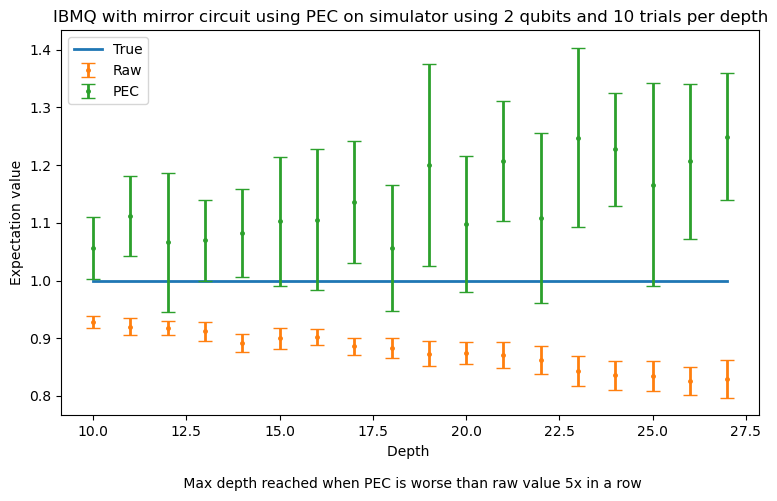

In [ ]:
plt.figure(figsize=(9, 5))
plot_depths = depths[:len(avg_true_values)]
kwargs = {"capsize": 5, "lw": 2}

plt.plot(plot_depths, avg_true_values, label="True", lw=2)

plt.errorbar(plot_depths, avg_noisy_values, yerr=std_noisy_values, label="Raw", **kwargs, fmt='o', ms=2.5)
plt.errorbar(plot_depths, avg_pec_values, yerr=std_pec_values, label="PEC", **kwargs, fmt='o', ms=2.5)

plt.xlabel("Depth \n \n Max depth reached when PEC is worse than raw value 5x in a row")
plt.ylabel("Expectation value")
plt.title(f"""IBMQ with {circuit_type} circuit using PEC on simulator using {n_qubits} qubits and {trials} trials per depth""")
plt.legend() 

save_data = False
import datetime
if save_data == True:

    dir_name = f"IBMQ_PEC_{circuit_type}_nqubits_{n_qubits}_shots_{shots}_trials_{trials}_Test_Depths"
    time_key = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    try:
        os.mkdir(dir_name)
    except FileExistsError:
        pass
    plt.savefig(os.path.join(dir_name,f"IBMQ_PEC_{circuit_type}_{n_qubits}"+ time_key +".pdf"))
    np.savetxt(os.path.join(dir_name, "cnot_counts" + time_key + ".txt"), cnot_counts)
    np.savetxt(os.path.join(dir_name, "oneq_counts" + time_key + ".txt"), oneq_counts)
    np.savetxt(os.path.join(dir_name, "true_values" + time_key + ".txt"), true_values)
    np.savetxt(os.path.join(dir_name, "noisy_values" + time_key + ".txt"), noisy_values)
    np.savetxt(os.path.join(dir_name, "pec_values" + time_key + ".txt"), pec_values)

    print("Data saved succesfully in", dir_name)

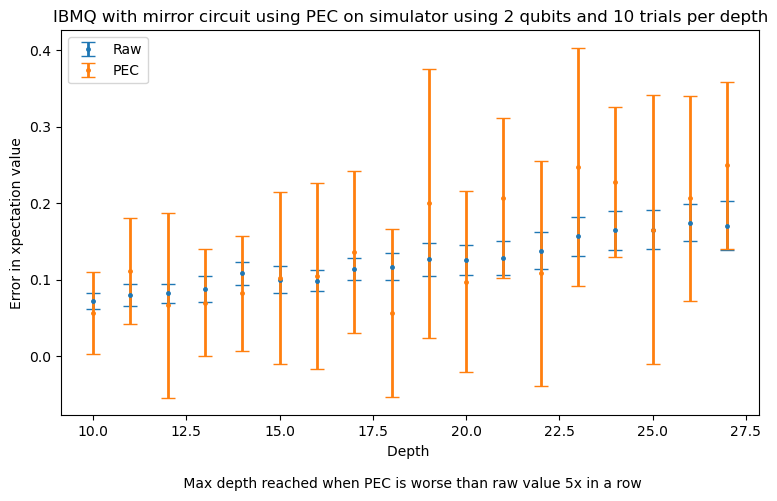

In [ ]:
# Plot Errors
noisy_errors = np.abs([a_i - b_i for a_i, b_i in zip(avg_noisy_values, avg_true_values)])
pec_errors = np.abs([a_i - b_i for a_i, b_i in zip(avg_pec_values, avg_true_values)])

plt.figure(figsize=(9, 5))
plot_depths = depths[:len(avg_true_values)]
kwargs = {"capsize": 5, "lw": 2}

plt.errorbar(plot_depths, noisy_errors, yerr=std_noisy_values, label="Raw", **kwargs, fmt='o', ms=2.5)
plt.errorbar(plot_depths, pec_errors, yerr=std_pec_values, label="PEC", **kwargs, fmt='o', ms=2.5)

plt.xlabel("Depth \n \n Max depth reached when PEC is worse than raw value 5x in a row")
plt.ylabel("Error in xpectation value")
plt.title(f"""IBMQ with {circuit_type} circuit using PEC on simulator using {n_qubits} qubits and {trials} trials per depth""")
plt.legend() 

save_data = False
import datetime
if save_data == True:

    dir_name = f"IBMQ_PEC_{circuit_type}_nqubits_{n_qubits}_shots_{shots}_trials_{trials}_Test_Depths"
    time_key = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    try:
        os.mkdir(dir_name)
    except FileExistsError:
        pass
    plt.savefig(os.path.join(dir_name,f"IBMQ_PEC_{circuit_type}_{n_qubits}_Errors"+ time_key +".pdf"))

    print("Data saved succesfully in", dir_name)

In [ ]:
noisy_backend = FakeTorino
# print(int(noisy_backend.num_qubits))
depths = np.arange(10,201)
trials = 10
n_qubits = 2
shots = 10000
num_samples = 100
circuit_type= "mirror" # "rb"

cnot_counts, oneq_counts, true_values, noisy_values, pec_values, avg_true_values, avg_noisy_values, avg_pec_values, std_true_values, std_noisy_values, std_pec_values = test_depths(depths, trials, n_qubits, shots, num_samples, circuit_type)

Status: On depth 10 with backend <class 'qiskit_ibm_runtime.fake_provider.backends.torino.fake_torino.FakeTorino'>



TypeError: '>' not supported between instances of 'int' and 'property'

Plot EV vs depth for noisy and mitigated results

In [ ]:
plt.figure(figsize=(9, 5))
plot_depths = depths[:len(avg_true_values)]
kwargs = {"capsize": 5, "lw": 2}

plt.plot(plot_depths, avg_true_values, label="True", lw=2)

plt.errorbar(plot_depths, avg_noisy_values, yerr=std_noisy_values, label="Raw", **kwargs, fmt='o', ms=2.5)
plt.errorbar(plot_depths, avg_pec_values, yerr=std_pec_values, label="PEC", **kwargs, fmt='o', ms=2.5)

plt.xlabel("Depth \n \n Max depth reached when PEC is worse than raw value 5x in a row")
plt.ylabel("Expectation value")
plt.title(f"""IBMQ with {circuit_type} circuit using PEC on simulator using {n_qubits} qubits and {trials} trials per depth""")
plt.legend() 

save_data = False
import datetime
if save_data == True:

    dir_name = f"IBMQ_PEC_{circuit_type}_nqubits_{n_qubits}_shots_{shots}_trials_{trials}_Test_Depths"
    time_key = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    try:
        os.mkdir(dir_name)
    except FileExistsError:
        pass
    plt.savefig(os.path.join(dir_name,f"IBMQ_PEC_{circuit_type}_{n_qubits}"+ time_key +".pdf"))
    np.savetxt(os.path.join(dir_name, "cnot_counts" + time_key + ".txt"), cnot_counts)
    np.savetxt(os.path.join(dir_name, "oneq_counts" + time_key + ".txt"), oneq_counts)
    np.savetxt(os.path.join(dir_name, "true_values" + time_key + ".txt"), true_values)
    np.savetxt(os.path.join(dir_name, "noisy_values" + time_key + ".txt"), noisy_values)
    np.savetxt(os.path.join(dir_name, "pec_values" + time_key + ".txt"), pec_values)

    print("Data saved succesfully in", dir_name)

Plot EV errors for noisy and mitigated results

In [ ]:
# Plot Errors
noisy_errors = np.abs([a_i - b_i for a_i, b_i in zip(avg_noisy_values, avg_true_values)])
pec_errors = np.abs([a_i - b_i for a_i, b_i in zip(avg_pec_values, avg_true_values)])

plt.figure(figsize=(9, 5))
plot_depths = depths[:len(avg_true_values)]
kwargs = {"capsize": 5, "lw": 2}

plt.errorbar(plot_depths, noisy_errors, yerr=std_noisy_values, label="Raw", **kwargs, fmt='o', ms=2.5)
plt.errorbar(plot_depths, pec_errors, yerr=std_pec_values, label="PEC", **kwargs, fmt='o', ms=2.5)

plt.xlabel("Depth \n \n Max depth reached when PEC is worse than raw value 5x in a row")
plt.ylabel("Error in xpectation value")
plt.title(f"""IBMQ with {circuit_type} circuit using PEC on simulator using {n_qubits} qubits and {trials} trials per depth""")
plt.legend() 

save_data = False
import datetime
if save_data == True:

    dir_name = f"IBMQ_PEC_{circuit_type}_nqubits_{n_qubits}_shots_{shots}_trials_{trials}_Test_Depths"
    time_key = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    try:
        os.mkdir(dir_name)
    except FileExistsError:
        pass
    plt.savefig(os.path.join(dir_name,f"IBMQ_PEC_{circuit_type}_{n_qubits}_Errors"+ time_key +".pdf"))

    print("Data saved succesfully in", dir_name)

## Testing widths

In [ ]:
def test_widths(depth, trials, widths, shots, num_samples, circuit_type):
    cnot_counts = []
    oneq_counts = []

    true_values=[]
    noisy_values = []
    pec_values = []

    avg_true_values=[]
    avg_noisy_values = []
    avg_pec_values = []

    std_true_values = []
    std_noisy_values = []
    std_pec_values = []

    still_useful_counter = 0

    for width_i in range(0,len(widths)):
        

        print("Status: On width", widths[width_i], "with backend", str(noisy_backend), end="\n\n")

        true_values_at_depth, noisy_values_at_depth, pec_values_at_depth, cnot_counts_at_depth, oneq_counts_at_depth = run_experiment(depth, trials, widths[width_i], shots, num_samples, circuit_type)
        
        # Store values
        true_values.append(true_values_at_depth)
        noisy_values.append(noisy_values_at_depth)
        pec_values.append(pec_values_at_depth)

        # Store averages
        avg_true_values.append(np.average(true_values_at_depth))
        avg_noisy_values.append(np.average(noisy_values_at_depth))
        avg_pec_values.append(np.average(pec_values_at_depth))
        
        # Store standard deviations
        std_true_values.append(np.std(true_values_at_depth, ddof=1))
        std_noisy_values.append(np.std(noisy_values_at_depth, ddof=1))
        std_pec_values.append(np.std(pec_values_at_depth, ddof=1))

        # Store gate counts
        cnot_counts.append(cnot_counts_at_depth)
        oneq_counts.append(oneq_counts_at_depth)

        # Check usefulness
        still_useful_at_depth, reason = still_useful(avg_true_values[width_i], 
                        avg_noisy_values[width_i], 
                        avg_pec_values[width_i], 
                        std_noisy_values[width_i], 
                        std_pec_values[width_i])
        
        # Count how many times in a row we're not useful, once we get to five (a trend, rather than a fluke bad spot) end it
        if still_useful_at_depth==True:
            print("Reset the count")
            still_useful_counter = 0
        elif still_useful_at_depth==False:
            print("Add count:", reason)
            still_useful_counter += 1 
        if still_useful_at_depth==False and still_useful_counter>=5:
            print("PEC is no longer useful after width = ", widths[width_i-1])
            break
    return cnot_counts, oneq_counts, true_values, noisy_values, pec_values, avg_true_values, avg_noisy_values, avg_pec_values, std_true_values, std_noisy_values, std_pec_values

In [ ]:
# noisy_backend = GenericBackendV2(90)
# widths = np.arange(2,70)
# trials = 10
# depth = 1
# shots = 10000
# num_samples = 100
# circuit_type= "long cnot" # "rb"
# save_data = False

# cnot_counts_w, oneq_counts_w, true_values_w, noisy_values_w, pec_values_w, avg_true_values_w, avg_noisy_values_w, avg_pec_values_w, std_true_values_w, std_noisy_values_w, std_pec_values_w = test_widths(depth, trials, widths, shots, num_samples, circuit_type)

Plot EV vs width for noisy and mitigated results

In [ ]:
# # Plot Values

# plt.figure(figsize=(9, 5))
# plot_widths = widths[:len(avg_true_values_w)]
# kwargs = {"capsize": 5, "lw": 2}

# # Plot true value
# plt.plot(plot_widths, avg_true_values_w, label="True", lw=2)

# # Plot scatter plots with error bars
# plt.errorbar(plot_widths, avg_noisy_values_w, yerr=std_noisy_values_w, label="Raw", **kwargs, fmt='o', ms=2.5)
# plt.errorbar(plot_widths, avg_pec_values_w, yerr=std_pec_values_w, label="PEC", **kwargs, fmt='o', ms=2.5)

# plt.xlabel("Width \n \n Max width reached when PEC is worse than raw value 5x in a row")
# plt.ylabel("Expectation value")
# plt.title(f"""IBMQ with {circuit_type} circuit using PEC on simulator using {depth} depth and {trials} trials per width""")
# plt.legend()

# # save_data = True
# import datetime
# if save_data == True:

#     dir_name = f"IBMQ_PEC_{circuit_type}_nqubits_{n_qubits}_shots_{shots}_trials_{trials}_Test_Widths"
#     time_key = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
#     try:
#         os.mkdir(dir_name)
#     except FileExistsError:
#         pass
#     plt.savefig(os.path.join(dir_name,f"IBMQ_PEC_{circuit_type}_{n_qubits}"+ time_key +".pdf"))
#     np.savetxt(os.path.join(dir_name, "cnot_counts" + time_key + ".txt"), cnot_counts_w)
#     np.savetxt(os.path.join(dir_name, "oneq_counts" + time_key + ".txt"), oneq_counts_w)
#     np.savetxt(os.path.join(dir_name, "true_values" + time_key + ".txt"), true_values_w)
#     np.savetxt(os.path.join(dir_name, "noisy_values" + time_key + ".txt"), noisy_values)
#     np.savetxt(os.path.join(dir_name, "pec_values" + time_key + ".txt"), pec_values_w)

#     print("Data saved succesfully in", dir_name)

Plot EV error vs width for noisy and mitigated results

In [ ]:
# # Plot Errors
# noisy_errors_w = np.abs([a_i - b_i for a_i, b_i in zip(avg_noisy_values_w, avg_true_values_w)])
# pec_errors_w = np.abs([a_i - b_i for a_i, b_i in zip(avg_pec_values_w, avg_true_values_w)])

# plt.figure(figsize=(9, 5))
# plot_depths = depths[:len(avg_true_values)]
# kwargs = {"capsize": 5, "lw": 2}

# plt.errorbar(plot_depths, noisy_errors_w, yerr=std_noisy_values, label="Raw", **kwargs, fmt='o', ms=2.5)
# plt.errorbar(plot_depths, pec_errors_w, yerr=std_pec_values, label="PEC", **kwargs, fmt='o', ms=2.5)

# plt.xlabel("Width \n \n Max width reached when PEC is worse than raw value 5x in a row")
# plt.ylabel("Error in expectation value")
# plt.title(f"""IBMQ with {circuit_type} circuit using PEC on simulator using {depth} depth and {trials} trials per width""")
# plt.legend()

# # save_data = True
# import datetime
# if save_data == True:

#     dir_name = f"IBMQ_PEC_{circuit_type}_nqubits_{n_qubits}_shots_{shots}_trials_{trials}_Test_Widths"
#     time_key = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
#     try:
#         os.mkdir(dir_name)
#     except FileExistsError:
#         pass
#     plt.savefig(os.path.join(dir_name,f"IBMQ_PEC_{circuit_type}_{n_qubits}_Errors"+ time_key +".pdf"))

#     print("Data saved succesfully in", dir_name)